### Report to 11020PHYS401200-Computational-Physics

### Part D : Contact Transfer Matrix in Y,X direction and do truncation by CYTNX 

* Author : Yen-Tung Lin
* ID : 109022802

### Reference
* Complexity and Criticality, Kim Christensen

### Model

* Classical Ising Model in 2 D : E = J $\sum_{<i,j>}S^{z}_{i}S^{z}_{j}$


### To do

* Contraction in X,Y and Trunction by two Methods
* * Method 1 : Find isometry using SVD
* * Method 2 : Find isometry by diagonalizing TT * TT.dagger (faster)

### To Calculate

* Transfer Matrix
* Eigenvalues of Transfer Matrix
* Corrlation length $\xi$=$\frac{1}{\log(\lambda_{0}/\lambda_{1})}$
* Determine the intersection of $\xi$ and do extrapolate to compare with exact Tc = $\frac{2}{\log(1+\sqrt(2)))}$
* Find the errors by comparing with exact contraction

### Import

In [1]:
import os
import math
import random
import cytnx as cy
from scipy.optimize import curve_fit
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array

### Define function : Print Diagram and Element

In [3]:
def ut_print(ut):
    ut.print_diagram()
    print(ut.get_block().numpy())

### Define function : Xmerge and Ymerge function

In [4]:
def Xmerge(TL,TR):
    Xmerge = cy.Network("network/Xmerge.net")
    Xmerge.PutUniTensors(['TL','TR'], [TL,TR])

    Uni_Tx = Xmerge.Launch()
    Uni_Tx.combineBonds([0,4])
    Uni_Tx.combineBonds([3,5])
    return Uni_Tx

def Ymerge(TU,TD):
    Ymerge = cy.Network("network/Ymerge.net")
    Ymerge.PutUniTensors(['TU','TD'], [TU,TD])

    Uni_Ty = Ymerge.Launch()
    Uni_Ty.combineBonds([1,10])
    Uni_Ty.combineBonds([2,11])
    return Uni_Ty

def T(t):
    m = np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],
                    [np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
    m_transpose = np.copy(m.transpose())
    CyT_M = cy.from_numpy(m)
    Uni_M = cy.UniTensor(CyT_M, rowrank = 1)
    # Uni_M.print_diagram()

    CyT_M_transpose = cy.from_numpy(m_transpose)
    Uni_M_transpose = cy.UniTensor(CyT_M_transpose, rowrank = 1)
    # Uni_M_transpose.print_diagram()

    Uni_M_up = Uni_M_transpose.clone()
    Uni_M_up.set_name("Uni_M_up")
    # ut_print(Uni_M_up)

    Uni_M_left = Uni_M_transpose.clone()
    Uni_M_left.set_name("Uni_M_left")
    # ut_print(Uni_M_left)

    Uni_M_right = Uni_M.clone()
    Uni_M_right.set_name("Uni_M_right")
    # ut_print(Uni_M_right)

    Uni_M_down = Uni_M.clone()
    Uni_M_down.set_name("Uni_M_down")
    # ut_print(Uni_M_down)

    delta = np.zeros((2,2,2,2))
    delta[0,0,0,0] = delta[1,1,1,1] = 1

    Delta = cy.from_numpy(delta)
    UniDelta = cy.UniTensor(Delta, rowrank = 2)
    UniDelta.set_labels([0,1,2,3])
    UniDelta.set_name("UniDelta")
    # ut_print(UniDelta)

    M_network = cy.Network("network/T.net")
    M_network.PutUniTensors(['mu','ml','mr','md','delta'], [Uni_M_up,Uni_M_left,Uni_M_right,Uni_M_down,UniDelta])
    # print(M_network)
    Uni_T=M_network.Launch()
    Uni_T.set_name("Uni_T")
    # ut_print(Uni_T)

    Uni_T_trace = Uni_T.clone().Trace(0, 3)
    return Uni_T, Uni_T_trace

def Identiy(L):
    np_I = np.identity(2**L)
    cy_I = cy.from_numpy(np_I)
    uni_I = cy.UniTensor(cy_I,rowrank=1)
    return uni_I

### Define M and Contract them to Build T

* $M = \begin{pmatrix}
     \sqrt{\cosh(\beta J)} & \sqrt{\sinh(\beta J)}\\
     \sqrt{\cosh(\beta J)} & -\sqrt{\sinh(\beta J)}\\
     \end{pmatrix}$

In [5]:
t = 1
J = 1
beta = 1/t
M = np.array([[np.sqrt(math.cosh(beta*J)), np.sqrt(math.sinh(beta*J))],
                [np.sqrt(math.cosh(beta*J)),-np.sqrt(math.sinh(beta*J))]])

* $T_{cy}$

In [6]:
t=1
m = np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],
                [np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
m_transpose = np.copy(m.transpose())
CyT_M = cy.from_numpy(m)
Uni_M = cy.UniTensor(CyT_M, rowrank = 1)
Uni_M.print_diagram()
# np.array([[np.sqrt(np.cosh(1/t)),np.sqrt(np.sinh(1/t))],[np.sqrt(np.cosh(1/t)),-np.sqrt(np.sinh(1/t))]])
CyT_M_transpose = cy.from_numpy(m_transpose)
Uni_M_transpose = cy.UniTensor(CyT_M_transpose, rowrank = 1)
Uni_M_transpose.print_diagram()

Uni_M_up = Uni_M_transpose.clone()
Uni_M_up.set_name("Uni_M_up")
ut_print(Uni_M_up)

Uni_M_left = Uni_M_transpose.clone()
Uni_M_left.set_name("Uni_M_left")
ut_print(Uni_M_left)

Uni_M_right = Uni_M.clone()
Uni_M_right.set_name("Uni_M_right")
ut_print(Uni_M_right)

Uni_M_down = Uni_M.clone()
Uni_M_down.set_name("Uni_M_down")
ut_print(Uni_M_down)

delta = np.zeros((2,2,2,2))
delta[0,0,0,0] = delta[1,1,1,1] = 1

Delta = cy.from_numpy(delta)
UniDelta = cy.UniTensor(Delta, rowrank = 2)
UniDelta.set_labels([0,1,2,3])
UniDelta.set_name("UniDelta")
ut_print(UniDelta)

M_network = cy.Network("network/T.net")
M_network.PutUniTensors(['mu','ml','mr','md','delta'], [Uni_M_up,Uni_M_left,Uni_M_right,Uni_M_down,UniDelta])
print(M_network)

Uni_T=M_network.Launch()
Uni_T.set_name("Uni_T")
CyT_T = Uni_T.get_block()
ut_print(Uni_T)

Uni_T_Ytrace = Uni_T.clone().Trace(0, 3)
Uni_T_Xtrace = Uni_T.clone().Trace(1, 2)

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : Uni_M_up
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         2 |____ 1  
           \             /     
            -------------      
[[ 1.24220797  1.24220797]
 [ 1.08406697 -1.08406697]]
-----------------------
tensor Name : Uni_M_left
tensor Rank : 2
bl

### Contraction in both direction

#### Dictionary to store Tensor

In [7]:
Uni_T_dic = {}
Uni_T_Xtrace_dic = {}
Uni_T_Ytrace_dic = {}
EIGVLE_Xtrace_dic = {}
EIGVLE_Ytrace_dic = {}

Uni_T_dic[(1,1)] = Uni_T
Uni_T_Ytrace_dic[(1,1)] = Uni_T_Ytrace.clone()
Uni_T_Xtrace_dic[(1,1)] = Uni_T_Xtrace.clone()

EIGVLE_Ytrace_dic[(1,1)], v = np.linalg.eigh(Uni_T_Ytrace.get_block().numpy())
EIGVLE_Xtrace_dic[(1,1)], v = np.linalg.eigh(Uni_T_Xtrace.get_block().numpy())

#### $T_{x=1,y=1},T_{x=2,y=2},T_{x=4,y=4}$

### Temperature Iteration & X,Y iteration

In [28]:
Llist = [1,2,4]
corr_Square = np.zeros((len(Llist),21),dtype=float)
Lambda_Square = np.zeros((len(Llist),2),dtype=float)
t = np.linspace(1,3,21)
for t_i in range(len(t)):
    Uni_T, y = T(t[t_i])
    TU = Uni_T.clone()
    TD = Uni_T.clone()
    TL = Uni_T.clone()
    TR = Uni_T.clone()

    Uni_T_dic_Square = {}
    Uni_T_trace_dic_Square = {}
    EIGVLE_dic_Square = {}

    for y_i in range(len(Llist)):
        if(y_i==0):
            Uni_T_temp3 = Uni_T.clone()
            Uni_T_dic_Square[(y_i,y_i)] = Uni_T_temp3.clone()
            Uni_T_trace_dic_Square[(y_i,y_i)] = Uni_T_temp3.Trace(0,3).clone()
            ee, v = la.eigh(Uni_T_temp3.Trace(0,3).get_block().numpy()) 
            EIGVLE_dic_Square[(y_i,y_i)] = ee
            Lambda_Square[y_i,0] = np.sort(EIGVLE_dic_Square[(y_i,y_i)])[-1]
            Lambda_Square[y_i,1] = np.sort(EIGVLE_dic_Square[(y_i,y_i)])[-2]
            corr_Square[y_i,t_i] = 1/np.log(Lambda_Square[y_i,0]/Lambda_Square[y_i,1])
        else:
            Uni_T_temp1 = Uni_T_temp3.clone()
            Uni_T_temp11 = Uni_T_temp3.clone()
            Uni_T_temp2 = Ymerge(Uni_T_temp1,Uni_T_temp11)
            Uni_T_temp22 = Uni_T_temp2.clone()
            Uni_T_temp3 = Xmerge(Uni_T_temp2,Uni_T_temp22)
            Uni_T_dic_Square[(y_i,y_i)] = Uni_T_temp3.clone()
            Uni_T_trace_dic_Square[(y_i,y_i)] = Uni_T_temp3.Trace(0,3).clone()
            ee, v = la.eigh(Uni_T_temp3.Trace(0,3).get_block().numpy()) 
            EIGVLE_dic_Square[(y_i,y_i)] = ee            
            Lambda_Square[y_i,0] = np.sort(ee)[-1]
            Lambda_Square[y_i,1] = np.sort(ee)[-2]
            corr_Square[y_i,t_i] = 1/np.log(Lambda_Square[y_i,0]/Lambda_Square[y_i,1])
            # print("shape:",np.shape(Uni_T_dic1[(y_i,y_i)].get_block().numpy())) 

In [10]:
TU = Uni_T_dic_Square[(2,2)].clone()
TD = Uni_T_dic_Square[(2,2)].clone()
I = Identiy(4)

In [11]:
network_Ytrace = cy.Network("./network/Ytrace.net")
network_Ytrace.PutUniTensors(['T','I'], [TU,I])
r = network_Ytrace.Launch()


In [12]:
cyT = cy.from_numpy(np.ones([2,3,4,5]))
cyU = cy.UniTensor(cyT,2)
cyU.print_diagram()
cyU.permute_([1,0,2,3],by_label = True)
cyU.print_diagram()
cyU.permute_([3,2,0,1],by_label = True)
cyU.print_diagram()



-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 2  
           |             |     
     1 ____| 3         5 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 3         4 |____ 2  
           |             |     
     0 ____| 2         5 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     3 ____| 5         2 |____ 0  
           |             |     
     2 ____| 4         3 |__

In [13]:
cyT = cy.from_numpy(np.ones([2,3,4,5]))
cyU = cy.UniTensor(cyT,2)
cyU.print_diagram()
cyU.permute_([3,2,1,0])
cyU.print_diagram()
cyU.set_label(0,1,2,3)
cyU.print_diagram()

cyU.permute_([1,0,2,3])
cyU.print_diagram()
# cyU.permute_([3,2,1,0])
# cyU.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 2  
           |             |     
     1 ____| 3         5 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     3 ____| 5         3 |____ 1  
           |             |     
     2 ____| 4         2 |____ 0  
           \             /     
            -------------      


TypeError: set_label() takes 3 positional arguments but 5 were given

In [14]:
TU.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 2  
           |             |     
     1 ____| 16       16 |____ 3  
           \             /     
            -------------      


## Trunction

In [15]:
Uni_to_be_truncate_In_X = Ymerge(TU,TD)
Uni_to_be_truncate_In_Y = Xmerge(Uni_to_be_truncate_In_X,Uni_to_be_truncate_In_X.clone())

: 

: 

### Method 1: Find isometry using SVD

In [47]:
# Llist = [1,2,4]
# corr_Square = np.zeros((len(Llist),21),dtype=float)
# Lambda_Square = np.zeros((len(Llist),2),dtype=float)
corr_Square1 = []
t = np.linspace(1,3,21)
for t_i in range(len(t)):
    TU, gg = T(t[t_i])
    # TU = Uni_T_dic_Square[(2,2)].clone()
    # TD = Uni_T_dic_Square[(2,2)].clone()

    #-------------------------------- Truncation in X-------------------------------
    print("X_truncation")

    Uni_to_be_truncate_In_X = Ymerge(TU,TU.clone())
    Uni_to_be_truncate_In_X.set_name("Uni_to_be_truncate_In_X")

    Uni_to_be_SVD = Uni_to_be_truncate_In_X.clone()
    Uni_to_be_SVD.print_diagram()
    Uni_to_be_SVD.permute_([1,0,3,2], rowrank = 1, by_label = True)
    Uni_to_be_SVD.print_diagram()

    Uni_to_be_SVD.combineBonds([0,3,2])
    Uni_to_be_SVD.set_name("Uni_to_be_SVD")

    Uni_to_be_SVD.print_diagram()

    S,U,Vd = cy.linalg.Svd_truncate(Uni_to_be_SVD, keepdim=16)
    S.set_name("S_x")
    U.set_name("U_x")
    U.print_diagram()

    U_dagger = U.Dagger().clone()
    U_dagger.set_name("U_dagger_x")
    U_dagger.print_diagram()


    network_Xtruncate = cy.Network("network/Xtruncation.net")
    network_Xtruncate.PutUniTensors(["Uni_to_be_truncate_In_X","U","UD"],[Uni_to_be_truncate_In_X,U,U_dagger])
    X_truncated = network_Xtruncate.Launch()
    network_Ytrace = cy.Network("./network/Ytrace.net")
    I = Identiy(4)
    network_Ytrace.PutUniTensors(['T','I'], [X_truncated,I])
    X_truncated_trace = network_Ytrace.Launch()
    X_truncated_trace.print_diagram()

    e,v = la.eigh(X_truncated_trace.get_block().numpy())
    print(np.log(e[-1]/e[-2]))

    #-------------------------------- Truncation in Y-------------------------------

    print("Y_truncation")

    Uni_to_be_truncate_In_Y = Xmerge(X_truncated,X_truncated.clone())
    Uni_to_be_truncate_In_Y.set_name("Uni_to_be_truncate_In_Y")

    Uni_to_be_SVD = Uni_to_be_truncate_In_Y.clone()
    Uni_to_be_SVD.print_diagram()

    Uni_to_be_SVD.permute_([0,1,3,2], rowrank = 1, by_label = True)
    Uni_to_be_SVD.print_diagram()

    Uni_to_be_SVD.combineBonds([1,3,2])
    Uni_to_be_SVD.set_name("Uni_to_be_SVD")
    Uni_to_be_SVD.print_diagram()

    S,U,Vd = cy.linalg.Svd_truncate(Uni_to_be_SVD, keepdim=16)

    S.set_name("S_y")
    U.set_name("U_y")
    U.print_diagram()

    U_dagger = U.Dagger().clone()
    U_dagger.set_name("U_dagger_y")
    U_dagger.print_diagram()

    network_Ytruncate = cy.Network("network/Ytruncation.net")
    network_Ytruncate.PutUniTensors(["Uni_to_be_truncate_In_Y","U","UD"],[Uni_to_be_truncate_In_Y,U,U_dagger])
    Y_truncated = network_Ytruncate.Launch()

    network_Ytrace = cy.Network("./network/Ytrace.net")
    I = Identiy(4)
    network_Ytrace.PutUniTensors(['T','I'], [Y_truncated,I])
    Y_truncated_trace = network_Ytrace.Launch()
    Y_truncated_trace.print_diagram()

    e,v = la.eigh(Y_truncated_trace.get_block().numpy())
    # Lambda_Square1[3,0] = e[-1]
    # Lambda_Square1[3,1] = e[-2]
    corr_Square1.append(1/np.log(e[-1]/e[-2]))

# print(np.log(e[-1]/e[-2]))


X_truncation
-----------------------
tensor Name : Uni_to_be_truncate_In_X
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 2  
           |             |     
     1 ____| 4         2 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : Uni_to_be_truncate_In_X
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         2 |____ 0  
           |             |     
           |           2 |____ 3  
           |             |     
           |           4 |____ 2  
           \             /     
            -------------      
-----------------------
tensor Name : Uni_to_be_SVD
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            --------

RuntimeError: 
# Cytnx error occur at cytnx::Tensor cytnx::linalg::Tensordot(const cytnx::Tensor&, const cytnx::Tensor&, const std::vector<long unsigned int>&, const std::vector<long unsigned int>&, const bool&, const bool&)
# error: the index L=3 and R=1 have different dimension!

# file : /home/kaihsinwu/.pyenv/versions/anaconda3-2020.11/conda-bld/cytnx_1638930041911/work/src/linalg/Tensordot.cpp (26)

In [43]:
corr_Square1

[0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262,
 0.2641423602360262]

In [15]:
len(Lylist)

3

In [39]:
corr_Square2[:]

[]

TypeError: not all arguments converted during string formatting

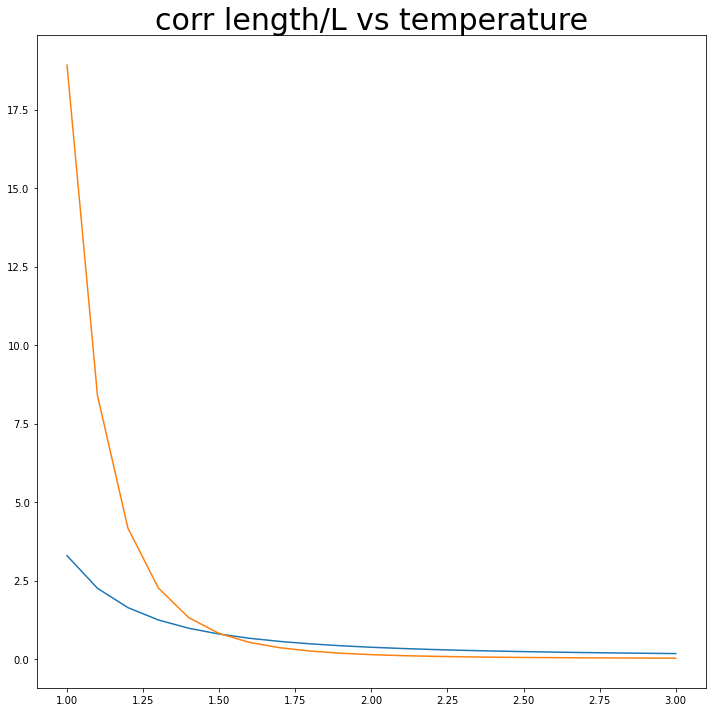

In [40]:
plt.figure(figsize = (12,12))
plt.title("corr length/L vs temperature", fontsize = 30)

for l in range(1,len(Lylist)):
    plt.plot(t[:], corr_Square[l,:]/(Lylist[l]*Lylist[l]), label = "Ly=%d" %(Lylist[l]))
corr_Square2 = []
for i in range(len(corr_Square1)):
    corr_Square2.append(corr_Square1[i]/64)

plt.plot(t[:], corr_Square2[:], label = "Ly=8" %(Lylist[l]))

plt.xlim(2,3)
plt.axvline(x=2.27,c='green',ls='--',lw=3,label="2.27")
plt.xticks(fontsize = 20 )
plt.xlabel("t",fontsize = 25)
plt.ylim(0,3)
plt.yticks(fontsize = 20 )
plt.ylabel("corr length/L",fontsize = 25)
plt.legend(fontsize = 20)

In [14]:
Y_to_be_truncate = Xmerge(X_truncated,X_truncated.clone())
Y_to_be_truncate.print_diagram()
Y_to_be_truncate.permute_([0,1,3,2], rowrank = 1, by_label = True)
Y_to_be_truncate.print_diagram()

Y_to_be_truncate.combineBonds([1,3,2])
Y_to_be_truncate.set_name("Y_to_be_truncate")
Y_to_be_truncate.print_diagram()

S,U,Vd = cy.linalg.Svd_truncate(Y_to_be_truncate, keepdim=16)
S.set_name("S")
U.set_name("U")
U.print_diagram()
U_dagger = U.Dagger().clone()
U_dagger.set_name("U_dagger")
U_dagger.print_diagram()

Y_truncated = Xmerge(X_truncated,X_truncated.clone())
network_Ytruncate = cy.Network("network/Ytruncation.net")
network_Ytruncate.PutUniTensors(["Y_to_be_bruncate","U","UD"],[Y_to_be_truncate,U,U_dagger])
Y_truncated = network_Xtruncate.Launch()
Y_truncated.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 256      16 |____ 2  
           |             |     
     1 ____| 16      256 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 256      16 |____ 1  
           |             |     
           |         256 |____ 3  
           |             |     
           |          16 |____ 2  
           \             /     
            -------------      
-----------------------
tensor Name : Y_to_be_truncate
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____|

RuntimeError: 
# Cytnx error occur at virtual void cytnx::RegularNetwork::PutUniTensor(const cytnx_uint64&, const cytnx::UniTensor&, const bool&)
# error: [ERROR][RegularNetwork][PutUniTensor] tensor name: [Y_to_be_bruncate], the rank of input UniTensor does not match the definition in network file.

# file : /home/travis/miniconda/envs/test-environment/conda-bld/cytnx_1614926727399/work/src/RegularNetwork.cpp (460)

In [ ]:
Y_to_be_truncate = Xmerge(X_truncated,X_truncated.clone())
Y_to_be_truncate.print_diagram()
Y_to_be_truncate.permute_([0,1,3,2], rowrank = 1, by_label = True)
Y_to_be_truncate.print_diagram()

Y_to_be_truncate.combineBonds([1,3,2])
Y_to_be_truncate.set_name("X_to_be_bruncate")

Y_to_be_truncate.print_diagram()
Y_to_be_truncate.print_diagram()
S,U,Vd = cy.linalg.Svd_truncate(Y_to_be_truncate, keepdim=16)
S.set_name("S")
U.set_name("U")
U.print_diagram()
U_dagger = U.Dagger().clone()
U_dagger.set_name("U_dagger")
U_dagger.print_diagram()

Y_to_be_truncate = Ymerge(X_truncated,X_truncated.clone())
network_Ytruncate = cy.Network("network/Ytruncation.net")
network_Ytruncate.PutUniTensors(["Y_to_be_bruncate","U","UD"],[Y_to_be_truncate,U,U_dagger])
Y_truncated = network_Xtruncate.Launch()
network_Xtrace = cy.Network("./network/Ytrace.net")
I = Identiy(4)
network_Ytrace.PutUniTensors(['T','I'], [Y_truncated,I])
r = network_Ytrace.Launch()
r.print_diagram()


In [26]:
network_Ytrace = cy.Network("./network/Ytrace.net")
I = Identiy(4)
network_Ytrace.PutUniTensors(['T','I'], [TU,I])
r = network_Ytrace.Launch()
r.print_diagram()

# ee,ev = la.eigh(TU.get_block().numpy())

e,v = la.eigh(r.get_block().numpy())

print(np.log(e[-1]/e[-2]))

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 1  
           \             /     
            -------------      
2.0884760803481894


In [25]:
X_truncate.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16       16 |____ 2  
           |             |     
     1 ____| 16       16 |____ 3  
           \             /     
            -------------      


In [14]:
S.print_diagram()
U.print_diagram()

U_dagger = U.Dagger()
U_dagger.set_name("U_dagger")
U_dagger.print_diagram()

U.print_diagram()
Vd.set_name("U_dagger")
Vd.print_diagram()



-----------------------
tensor Name : S
tensor Rank : 2
block_form  : false
is_diag     : True
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 16       16 |____ -2 
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 16       16 |____ -1 
           \             /     
            -------------      
-----------------------
tensor Name : U_dagger
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 16       16 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx devic

In [53]:
S.print_diagram()
U.print_diagram()

U_dagger = U.Dagger()
U_dagger.print_diagram()
U.print_diagram()

U_dagger.permute_([10,2], rowrank = 1, by_label = True).print_diagram()
Vd.print_diagram()


-----------------------
tensor Name : S
tensor Rank : 2
block_form  : false
is_diag     : True
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 2         2 |____ -2 
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         2 |____ -1 
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 2         4 |____ 1  
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU


RuntimeError: 
# Cytnx error occur at virtual void cytnx::DenseUniTensor::permute_(const std::vector<long int>&, const cytnx_int64&, const bool&)
# error: [ERROR] label 10 does not exist in current UniTensor.

# file : /home/travis/miniconda/envs/test-environment/conda-bld/cytnx_1614926727399/work/src/DenseUniTensor.cpp (182)

In [61]:
U_dagger.print_diagram()
U_dagger.permute_([1,0], rowrank = 1, by_label = True)
U_dagger.print_diagram()


-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         2 |____ -1 
           \             /     
            -------------      


RuntimeError: 
# Cytnx error occur at virtual void cytnx::DenseUniTensor::permute_(const std::vector<long int>&, const cytnx_int64&, const bool&)
# error: [ERROR] label 0 does not exist in current UniTensor.

# file : /home/travis/miniconda/envs/test-environment/conda-bld/cytnx_1614926727399/work/src/DenseUniTensor.cpp (182)

In [45]:
cy.Contract(U.Dagger(),T_y2).print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 2         4 |____ 2  
           |             |     
     0 ____| 2         2 |____ 3  
           \             /     
            -------------      


In [16]:
T_y2= Ymerge(TU,TD)

Uni_to_be_truncate_l = T_y2.clone()
Uni_to_be_truncate_l.print_diagram()
Uni_to_be_truncate_l.permute_([1,0,3,2], rowrank = 3, by_label = True)
Uni_to_be_truncate_l.print_diagram()
Uni_to_be_truncate_l.combineBonds([0,3,1], by_label = True)
Uni_to_be_truncate_l.print_diagram()
S,U_l,Vd = cy.linalg.Svd_truncate(Uni_to_be_truncate_l, keepdim=4)
U_l.set_name("U")
U_l_dagger = U_l.Dagger().clone()
U_l_dagger.set_name("U_l_dagger")


-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 2  
           |             |     
     1 ____| 4         2 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         4 |____ 2  
           |             |     
     0 ____| 2           |        
           |             |     
     3 ____| 2           |        
           \             /     
            -------------      
-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 16        4 |__

In [25]:
print(U)


Tensor name: U
braket_form : False
is_diag    : False

Total elem: 16
type  : Double (Float64)
cytnx device: CPU
Shape : (4,4)
[[-9.90701e-01 0.00000e+00 -0.00000e+00 1.36057e-01 ]
 [-0.00000e+00 7.07107e-01 -7.07107e-01 -0.00000e+00 ]
 [-0.00000e+00 7.07107e-01 7.07107e-01 0.00000e+00 ]
 [-1.36057e-01 0.00000e+00 -0.00000e+00 -9.90701e-01 ]]






In [28]:
print(Vd.Dagger())


Tensor name: 
braket_form : False
is_diag    : False

Total elem: 16
type  : Double (Float64)
cytnx device: CPU
Shape : (4,4)
[[-9.90701e-01 -2.08195e-17 2.08195e-17 1.36057e-01 ]
 [0.00000e+00 -7.07107e-01 7.07107e-01 0.00000e+00 ]
 [0.00000e+00 -7.07107e-01 -7.07107e-01 -0.00000e+00 ]
 [-1.36057e-01 1.55623e-16 -1.55623e-16 -9.90701e-01 ]]






In [18]:
print(U_dagger)


Tensor name: U
braket_form : False
is_diag    : False

Total elem: 16
type  : Double (Float64)
cytnx device: CPU
Shape : (4,4)
[[-9.90701e-01 -0.00000e+00 -0.00000e+00 -1.36057e-01 ]
 [0.00000e+00 7.07107e-01 7.07107e-01 0.00000e+00 ]
 [-0.00000e+00 -7.07107e-01 7.07107e-01 -0.00000e+00 ]
 [1.36057e-01 -0.00000e+00 0.00000e+00 -9.90701e-01 ]]






In [19]:
print(U)


Tensor name: U
braket_form : False
is_diag    : False

Total elem: 16
type  : Double (Float64)
cytnx device: CPU
Shape : (4,4)
[[-9.90701e-01 0.00000e+00 -0.00000e+00 1.36057e-01 ]
 [-0.00000e+00 7.07107e-01 -7.07107e-01 -0.00000e+00 ]
 [-0.00000e+00 7.07107e-01 7.07107e-01 0.00000e+00 ]
 [-1.36057e-01 0.00000e+00 -0.00000e+00 -9.90701e-01 ]]






In [17]:
T_y2.print_diagram()
U.print_diagram()
U_dagger.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 4
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ 2  
           |             |     
     1 ____| 4         2 |____ 3  
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         4 |____ -1 
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 4         4 |____ 1  
           \             /     
            -------------      


In [43]:
S,U,Vd = cy.linalg.Svd(Uni_to_be_truncate)

In [44]:
Vd.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -2 ____| 4        16 |____ 0  
           \             /     
            -------------      


In [45]:
U.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     1 ____| 4         4 |____ -1 
           \             /     
            -------------      


In [46]:
S.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : True
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 4         4 |____ -2 
           \             /     
            -------------      


In [31]:
S,U,Vd = cy.linalg.Svd_truncate(T_y2, keepdim=4)

In [32]:
Vd.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 3
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
    -2 ____| 4         4 |____ 2  
           |             |     
           |           2 |____ 3  
           \             /     
            -------------      


In [33]:
S.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 2
block_form  : false
is_diag     : True
on device   : cytnx device: CPU
            -------------      
           /             \     
    -1 ____| 4         4 |____ -2 
           \             /     
            -------------      


In [34]:
U.print_diagram()

-----------------------
tensor Name : 
tensor Rank : 3
block_form  : false
is_diag     : False
on device   : cytnx device: CPU
            -------------      
           /             \     
     0 ____| 2         4 |____ -1 
           |             |     
     1 ____| 4           |        
           \             /     
            -------------      


### Method 2 : Find isometry by diagonalizing TT * TT.dagger (faster)

### Check with Y Iteration Case